# About

Script to generate figures using the myelin plasticity model with adaptive conduction velocities. Use the MATLAB script 'sec5_vel_numerics.mat' to generate the data set.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec5_vel_numerics'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)
dir_im_plas = os.path.join(dir_im, 'plas')
dir_im_noplas = os.path.join(dir_im, 'noplas')

filenames_plas = os.listdir(dir_im_plas)
filenames_noplas = os.listdir(dir_im_noplas)
filenames_plas.remove('parameters.mat')
filenames_noplas.remove('parameters.mat')

# Import data

## Parameters

In [3]:
dir_par = os.path.join(dir_im_plas, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

N = dict_par['N'][0,0]
g = dict_par['g'][0,0]
w0 = dict_par['omega0'][0,0]
alphatau = dict_par['alphatau'][0,0]
betatau = dict_par['betatau'][0,0]
gain = dict_par['gain'][0,0]

distm_arr = dict_par['distm_arr']
vel0 = dict_par['vel0'][0,0]
vel_min = dict_par['vel_min'][0,0]
vel_max = dict_par['vel_max'][0,0]

t0 = dict_par['t0'][0,0]
tf = dict_par['tf'][0,0]

initstd = dict_par['std'][0,0]
initOmegas = dict_par['freq_arr']
L_Omega = dict_par['L_freq'][0,0]

## Processing function

In [4]:
def compile_data(directory, filenames, ind0, asy=0.05):
    '''
    Compiles the asymptotic values for the frequency and the order parameter, using the last asy percentage of the array.
    For the ind0 dataset, also compiles the full arrays to be plotted.
    '''
    
    # Compiled arrays
    asyOmegas = np.zeros(len(filenames))
    asyOrders = np.zeros(len(filenames))
    meanLens = np.zeros(len(filenames))
    meantaufs = np.zeros(len(filenames))
    vartaufs = np.zeros(len(filenames))
    
    for i in range(len(filenames)):
        
        # Import .mat file
        filename = filenames[i]
        dir_mat = os.path.join(directory, filename)
        dict_mat =  sio.loadmat(dir_mat)

        # Get g, tau0 indices
        ind_file = filename.split('.')[0]
        ind = int(ind_file)
        
        # Compile solution dictionary
        sol = {'t': np.reshape(dict_mat['t'], -1),
               'y': dict_mat['y'],
               'yp': dict_mat['yp'],
               'vel': dict_mat['vel'],
               'velp': dict_mat['velp'],
               'tau': dict_mat['tau'],
               'dist': dict_mat['dist'],
               'distm': dict_mat['distm'][0,0]
              }
        
        initOmega = dict_mat['hist_freq'][0,0]
        initstd = dict_mat['hist_std'][0,0]
        meanLen = dict_mat['distm']
        arrOmega = asylib.weight_avg(sol['t'], sol['yp'], asy)
        asyOmega = np.sum(arrOmega) / arrOmega.size
    
        # Order parameter
        orderY = funlib.order(sol['y'])
        sol['order'] = orderY.copy()
        orderY = orderY.reshape(-1,1)
        asyOrder = np.sum(asylib.weight_avg(sol['t'], orderY, asy))
        
        if ind == ind0:
            sol1 = sol.copy()
        
        # Delay at final time
        tauf = sol['tau'][-1,:]
        mean_tauf = np.average(tauf)
        var_tauf = np.var(tauf)
        
        # Store
        asyOrders[ind] = asyOrder
        asyOmegas[ind] = asyOmega
        meanLens[ind] = meanLen
        meantaufs[ind] = mean_tauf
        vartaufs[ind] = var_tauf
    
    # Sort
    inds_sort = np.argsort(meanLens)
    meanLens = meanLens[inds_sort]
    asyOrders = asyOrders[inds_sort]
    asyOmegas = asyOmegas[inds_sort]
    meantaufs = meantaufs[inds_sort]
    vartaufs = vartaufs[inds_sort]
    
    
    # Compile
    d = {'sol': sol1,
         'distm': meanLens,
         'asyOrders': asyOrders,
         'asyOmegas': asyOmegas,
         'taufms': meantaufs,
         'taufvars': vartaufs
         }
    
    return d

## Process arrays

In [5]:
# Asy:
asy = 0.05

# Select which injury index to plot:
ind0 = 8

# Obtain compiled arrays
plas = compile_data(dir_im_plas, filenames_plas, ind0, asy=asy)
noplas = compile_data(dir_im_noplas, filenames_noplas, ind0, asy=asy)

# ARRAYS TO PLOT
solp = plas['sol']
solnp = noplas['sol']

taup_s = solp['tau'][0,:]
taup_f = solp['tau'][-1,:]

# Asymptotic arrays
distm_p = plas['distm']
distm_np = noplas['distm']

asyOrders_p = plas['asyOrders']
asyOrders_np = noplas['asyOrders']
asyOmegas_p = plas['asyOmegas']
asyOmegas_np = noplas['asyOmegas']

asyTaum = plas['taufms']
asyTauVar = plas['taufvars']

# Sample
num_inds = 100
inds = np.random.choice(np.arange(N**2-1), size=num_inds, replace=False)

# Figure (solo)

## Options

In [6]:
# Plot positions [left, bottom, width, height]  
bbox1 = [0.1, 0.70, 0.40, 0.20] # Fig 1a: Frequency over time
bbox2 = [0.6, 0.70, 0.40, 0.20] # Fig 1b: Order over time
bbox3 = [0.1, 0.40, 0.40, 0.20] # Fig 1c: Velocity over time
bbox4 = [0.6, 0.40, 0.40, 0.20] # Fig 1d: Delay histogram
bbox5 = [0.1, 0.10, 0.90, 0.20] # Fig 6b: Histogram of delays

line_options = {'linewidth': 1.0,
                'alpha': 0.6
               }
lw_hist = 1.0

# Histogram colours
alpha_col = 0.2
col0 = 'black'
col1 = 'orange'
col2 = 'blue'
col0_alp = clr.to_rgba(col0, alpha=alpha_col)
col1_alp = clr.to_rgba(col1, alpha=alpha_col)
col2_alp = clr.to_rgba(col2, alpha=alpha_col)

# Colourmaps
colormap_p = plt.cm.get_cmap('cool')
colormap_np = plt.cm.get_cmap('OrRd')
colorlist_p = [colormap_p(i) for i in np.linspace(0, 0.99, N)]
colorlist_np = [colormap_np(i) for i in np.linspace(0, 0.99, N)]

# Bins
BINS = np.arange(0, np.ceil(np.max(taup_s)), 0.5)
bin_range = (0, 8)
num_bins = 30

## Generate plot

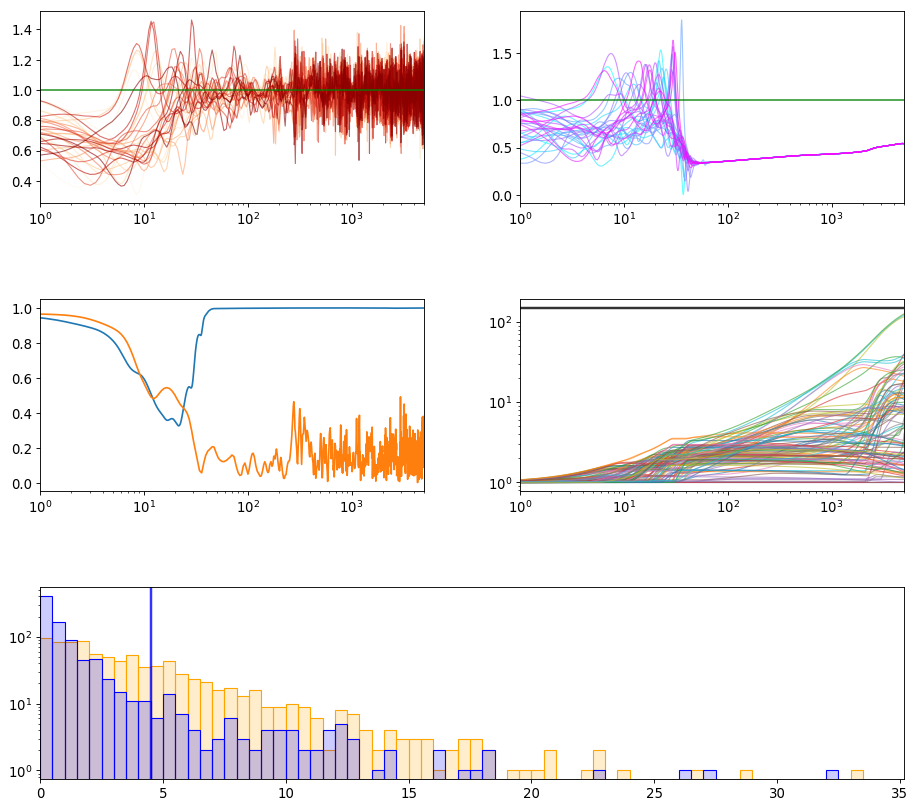

In [31]:
fig, ax = plt.subplots(5, figsize=(12,12), dpi=80)

# Set positions
ax[0].set_position(bbox1)
ax[1].set_position(bbox2)
ax[2].set_position(bbox3)
ax[3].set_position(bbox4)
ax[4].set_position(bbox5)

# Compare plasticities
ax[0].set_prop_cycle(color=colorlist_np)
ax[0].plot(solnp['t'], solnp['yp'], **line_options)
ax[0].axhline(y=w0, color='green', alpha=0.8)
ax[0].set_xscale('log')

ax[1].set_prop_cycle(color=colorlist_p)
ax[1].plot(solp['t'], solp['yp'], **line_options)
ax[1].axhline(y=w0, color='green', alpha=0.8)
ax[1].set_xscale('log')

# Orders
ax[2].plot(solp['t'], solp['order'])
ax[2].plot(solnp['t'], solnp['order'])
ax[2].set_xscale('log')

# Velocities
ax[3].plot(solp['t'], solp['vel'][:,inds], **line_options)
ax[3].axhline(y=vel_max, color='black', linewidth=2.2, alpha=0.8)
ax[3].set_xscale('log')
ax[3].set_yscale('log')

# Adjust axes
for i in range(len(ax)-1):
    ax[i].set_xlim(left=t0+1, right=tf)
    
# Histogram
BINS1 = ax[4].hist(taup_s, bins=BINS, density=False, log=True, color=col1_alp, edgecolor=col1, linewidth=lw_hist)
BINS2 = ax[4].hist(taup_f, bins=BINS, density=False, log=True, color=col2_alp, edgecolor=col2, linewidth=lw_hist)
ax[4].axvline(x=solp['distm'], color='blue', linewidth=2.2, alpha=0.8)
ax[4].set_xlim(left=0)

# Axis font size
for i in range(len(ax)):
    ax[i].tick_params(labelsize=12)

## Statistics

In [8]:
distm_plot = solp['distm']
print(f'Mean distance = {distm_plot}')

Mean distance = 4.5


# Figure (multi)

## Options

In [16]:
# Plot positions [left, bottom, width, height]  
Bbox1 = [0.1, 0.60, 0.35, 0.35] # Fig 1a: Asymptotic frequency
Bbox2 = [0.1, 0.10, 0.35, 0.35] # Fig 1b: Asymptotic order
Bbox3 = [0.55, 0.10, 0.4, 0.85] # Fig 1c: Velocity over time

# Colours
col_p = 'blue'
col_np = 'red'

col_m = 'orange'
col_v = 'purple'

alp1 = 0.7

# Markersize
lw = 1.0
lw2 = 1.2
ms = 16
ms2 = 25

# Theoretical y=x line
x_arr = np.linspace(-10, 10, num=1000)
y_arr = np.linspace(-10, 10, num=1000)

## Generate plot

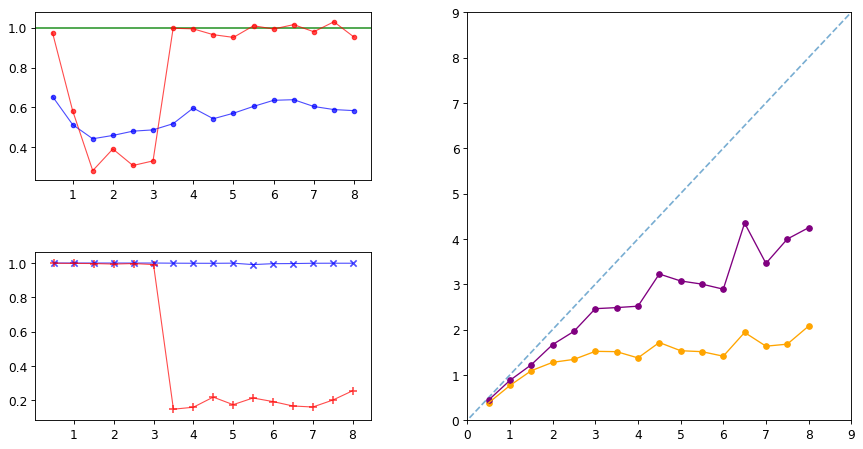

In [22]:
fig, ax = plt.subplots(3, figsize=(12,6), dpi=80)

# Set positions
ax[0].set_position(Bbox1)
ax[1].set_position(Bbox2)
ax[2].set_position(Bbox3)

# Plot asymptotics
ax[0].plot(distm_p, asyOmegas_p, lw=lw, alpha=alp1, color=col_p)
ax[0].plot(distm_np, asyOmegas_np, lw=lw, alpha=alp1, color=col_np)
ax[0].scatter(distm_p, asyOmegas_p, s=ms, alpha=alp1, color=col_p)
ax[0].scatter(distm_np, asyOmegas_np, s=ms, alpha=alp1, color=col_np)
ax[0].axhline(y=w0, color='green', alpha=0.8, zorder=0)

ax[1].plot(distm_p, asyOrders_p, lw=lw, alpha=alp1, color=col_p)
ax[1].plot(distm_np, asyOrders_np, lw=lw, alpha=alp1, color=col_np)
ax[1].scatter(distm_p, asyOrders_p, s=2*ms, alpha=alp1, marker='x', color=col_p)
ax[1].scatter(distm_np, asyOrders_np, s=3*ms, alpha=alp1, marker='+', color=col_np)

# Compare means and variances
ax[2].plot(x_arr, y_arr, ls='dashed', alpha=0.6, zorder=0)
ax[2].plot(distm_p, asyTaum, lw=lw2, color=col_m, zorder=2)
ax[2].plot(distm_p, np.sqrt(asyTauVar), lw=lw2, color=col_v, zorder=2)
ax[2].scatter(distm_p, asyTaum, s=ms2, color=col_m, zorder=2)
ax[2].scatter(distm_p, np.sqrt(asyTauVar), s=ms2, color=col_v, zorder=2)

# Edit axes
ax[2].set_xlim(left=0, right=np.max(distm_p)+1)
ax[2].set_ylim(bottom=0, top=np.max(distm_p)+1)

# Axis font size
for i in range(len(ax)):
    ax[i].tick_params(labelsize=11)